# ДЗ №3

Используется датасет https://www.kaggle.com/mlg-ulb/creditcardfraud#creditcard.csv

Для запуска блокнота, скачайте датасет и поместите его в директорию data.

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import random

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import RobustScaler
from sklearn.svm import OneClassSVM
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

from scipy.spatial.distance import cdist

warnings.filterwarnings("ignore")

random.seed(123)
np.random.seed(123)

raw_data_full = pd.read_csv('data/creditcard.csv')

## EDA

Соберем информацию о датасете (количество записей, типы данных, пустые значения).

In [72]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
raw_data_full.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [73]:
raw_data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Датасет очень большой, поэтому возьмем лишь его часть, что бы ускорить обучение моделей.

Приведем данные к одному маштабу.

In [74]:
# будем работать только с частью датасета. Однако мы не будем использовать все 50000 записей. Далее мы разделим его на тренировочный и тестовый выборки.
raw_data = raw_data_full.sample(n=50000)

# создадим копию датасета, которая содержит только признаки
raw_data_features = raw_data.drop(columns=['Class'])

# приводим данные к одному маштабу
scaled_data_arr = RobustScaler().fit_transform(raw_data_features)
scaled_data = pd.DataFrame(data=scaled_data_arr, columns=raw_data_features.columns)

# разделяем датасет на тестовую и обучающую выборки - это понадобится для некоторых алгоритмов
X_train, X_test, y_train, y_test = train_test_split(scaled_data, raw_data['Class'],
                                                    test_size=0.5, # делим пополам, потому что датасет все еще очень большой. Таким образом размер тестовых и обучающих выборок будет 25000 записей.
                                                    random_state=123)

Построим гистограммы по каждой колонке.

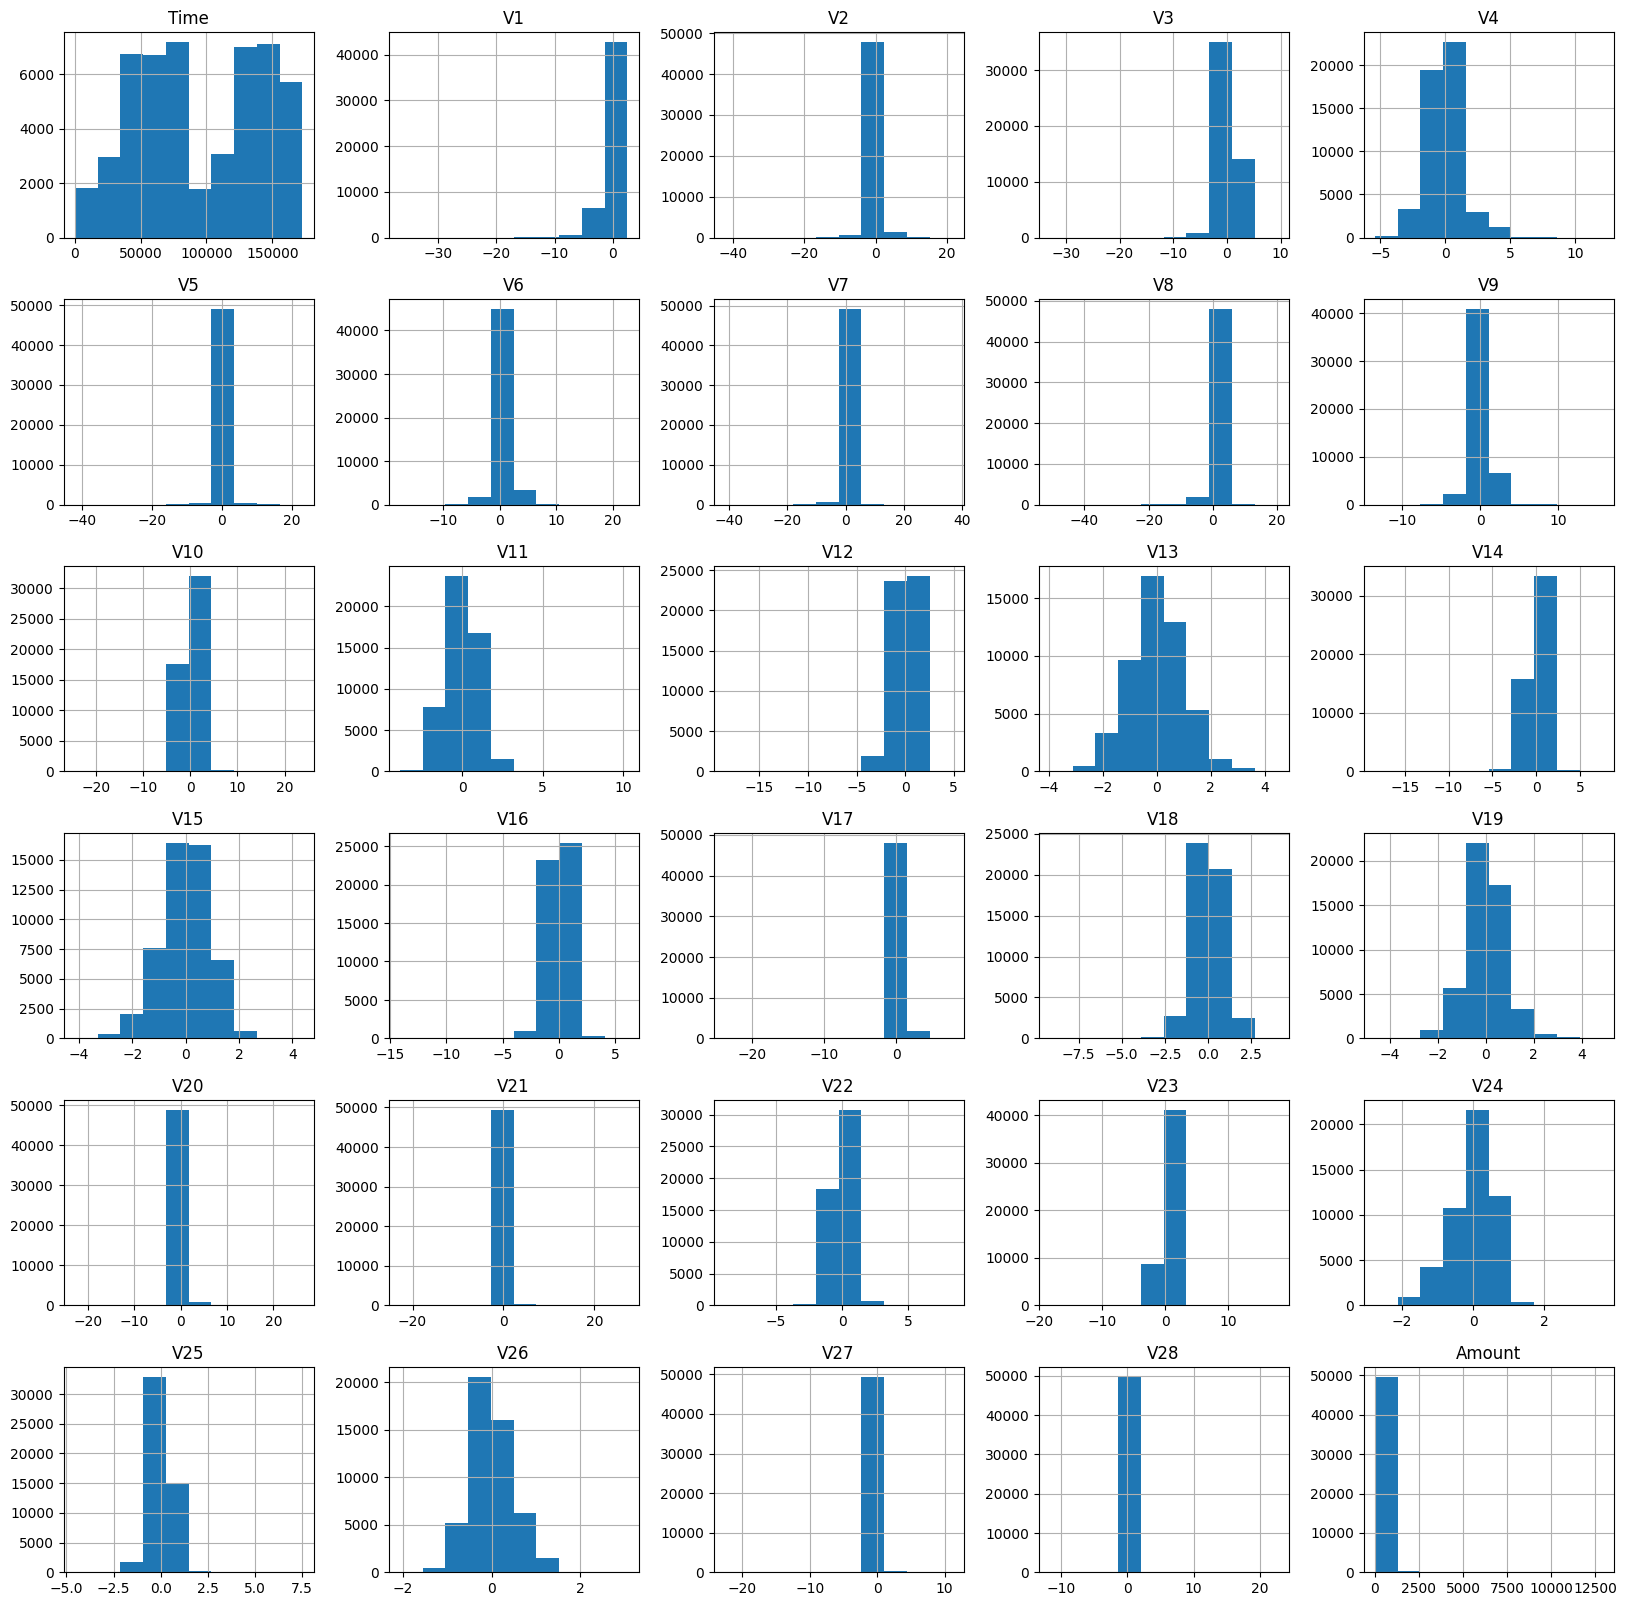

In [89]:
raw_data_features.hist(figsize=(20, 20))
plt.show()

Следующие признаки имеют распределение, близкое к нормальному: V4, V7, V9, V11, V13, V14, V15, V18, V19, V20, V21, V22, V24, V25, V26, V27. Их можно будет использовать для поиска аномалий методом трех сигм.

Проверим, есть ли признаки с сильной корреляцией.

In [76]:
corr_matrix = raw_data_features.corr()
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(np.bool_))

high_corr = [column for column in lower.columns if any(abs(lower[column]) > 0.6)]
print(high_corr)

[]


Найдем описательные статистики: стандартное отклонение, медиану, первый и третий квантили.

Медиану и квантили удобно визуализировать при помощи ящиков с усами.

Признак | Стандартное отклонение
--------------------------------
Time | 47302.41487821682
V1 | 1.9574247674518588
V2 | 1.637331819391895
V3 | 1.5461436050641029
V4 | 1.4144245810823945
V5 | 1.3494153527760084
V6 | 1.3071335872615044
V7 | 1.228504830007931
V8 | 1.2090679939872642
V9 | 1.107622181630775
V10 | 1.1120027140165198
V11 | 1.0233544492851616
V12 | 1.009316321168378
V13 | 1.0010772364571563
V14 | 0.9712235910767423
V15 | 0.911292215786882
V16 | 0.8823683608996693
V17 | 0.8660181143906066
V18 | 0.8412628518999623
V19 | 0.8148624845296663
V20 | 0.7505414704617857
V21 | 0.7292066515262047
V22 | 0.7252556205967153
V23 | 0.5596059771145536
V24 | 0.6041894414506718
V25 | 0.5209120366107248
V26 | 0.4860443982863955
V27 | 0.40900811307936924
V28 | 0.3317104149880509
Amount | 243.27862576656935


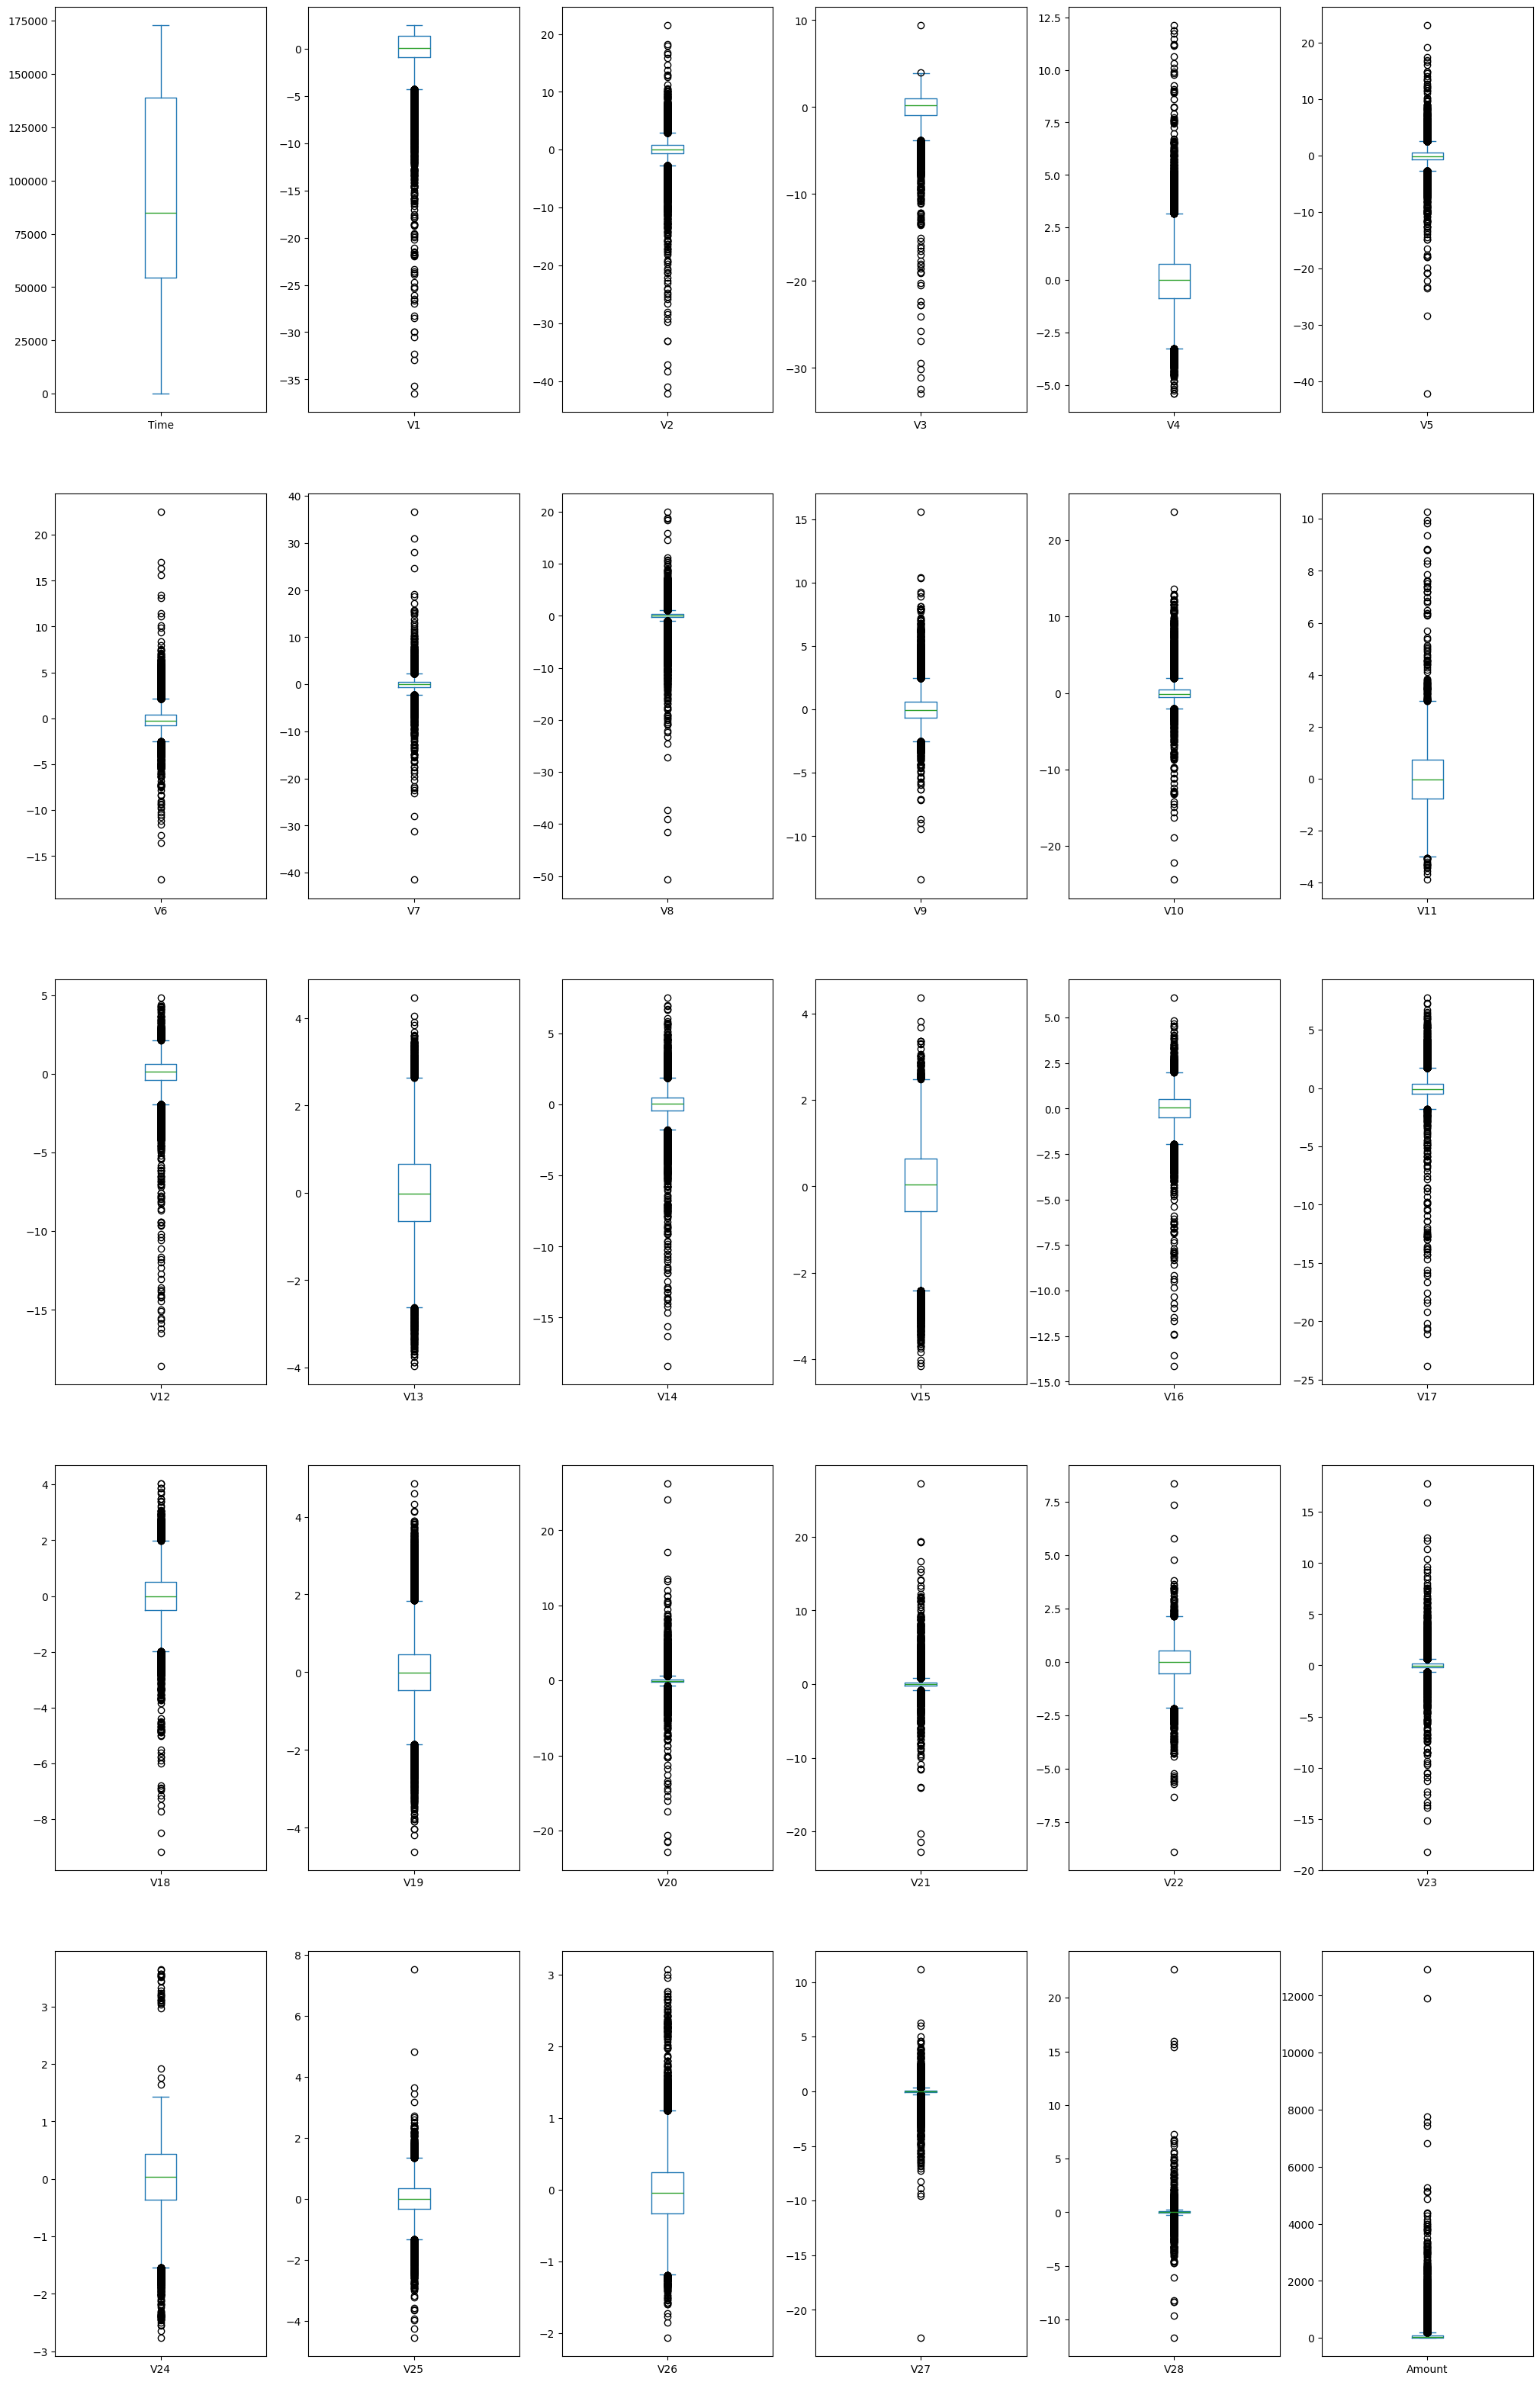

In [77]:
# находим стандартное отклонение
print('Признак | Стандартное отклонение')
print('--------------------------------')

for feature_name in raw_data_features:
    feature = raw_data_features[feature_name]
    std = np.std(feature)
    print(f'{feature_name} | {std}')

n_cols = 6
n_rows = int(raw_data_features.shape[1] / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 40))

# строим ящики с усами
row = 0
col = 0

for ax, feature in enumerate(raw_data_features):
    raw_data_features[feature].plot.box(ax=axes[row, col])
    col += 1
    if col > 5:
        row += 1
        col = 0

## Экспертная оценка

Найдем оценку на основании исходного датасета, а не той части, которую мы выбрали для обучения моделей. Ведь нам нужно оценить способность моделей к обобщению, а значит нужна максимально точная оценка.

In [78]:
class_counts = raw_data_full['Class'].value_counts()
FRAUD_PERCENT = (class_counts[1] / class_counts[0]) * 100
print(f'Процент подозрительных записей: {FRAUD_PERCENT} %')

Процент подозрительных записей: 0.17304750013189596 %


## Поиск аномалий

### Утилиты

In [79]:
def normalize_outliers(outliers: list):
    '''
    Возвращает список аномалий, в котором каждый элемент может принимать значения 0 или 1.
    1 - аномалия
    0 - нет аномалии
    '''
    return np.array([1 if label == -1 else 0 for label in outliers])

def print_report(y_true, y_pred):
    report = classification_report(y_true, y_pred)
    print(f'Classification report:\n{report}')

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f'Confusion matrix:')
    print(f'-----------------')
    print(f'True Positive = {tp} | False Positive = {fp}')
    print(f'False Negative = {fn} | True Negative = {tn}')
    print(f'-----------------')

def show_scatter(data, labels):
    data_with_labels = data.copy()
    data_with_labels['is_outlier'] = labels

    # берем только часть датасета, в противном случае визуализация займет слишком много времени
    data_to_visualize = data_with_labels.sample(n=1000)
    labels_to_visualize = data_to_visualize['is_outlier']
    
    data_to_visualize.drop(columns=['is_outlier'])

    plt.figure(figsize=(10, 10))
    transformed_data = TSNE(n_components=2, n_jobs=-1).fit_transform(data_to_visualize)
    plt.scatter(transformed_data[:, 0], transformed_data[:, 1], c=labels_to_visualize)
    plt.show()

### Три сигмы

Если значение признака выходит за пределы трех сигм, значит образец является аномалией. Только нормально распределенные признаки могут участвовать в анализе: V4, V7, V9, V11, V13, V14, V15, V18, V19, V20, V21, V22, V24, V25, V26, V27.

In [80]:
sigmas_labels = np.zeros(shape=(X_test.shape[0], 1))
for feature in ['V4', 'V7', 'V9', 'V11', 'V13', 'V14', 'V15', 'V18', 'V19', 'V20', 'V21', 'V22', 'V24', 'V25', 'V26', 'V27']:
    feature_values = X_test[feature]
    sigma = np.std(feature_values)
    s3 =  sigma * 3
    m = np.median(feature_values)
    for i, value in enumerate(feature_values.to_numpy()):
        if value < m - s3 or value > m + s3:
            sigmas_labels[i] = 1

### Ящики с усами

Этот алгоритм нечуствителен к форме распределения, поэтому его можно применить ко всем признакам.

Алгоритм поиска аномалий:<br/>

1. Найти Q1, Q3 и IQR, где:<br/>
Q1 - первый квантиль<br/>
Q3 - третий квантиль<br/>
IQR = Q3 - Q1<br/>

2. Аномалии - это все значения за пределами диапазона [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR].

In [81]:
boxplot_labels = np.zeros(shape=(X_test.shape[0], 1))
for feature in X_test.columns:
    feature_values = X_test[feature]
    q1 = np.quantile(feature_values, 0.25)
    q3 = np.quantile(feature_values, 0.75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    for i, value in enumerate(feature_values.to_numpy()):
        if value < lower_bound or value > upper_bound:
            boxplot_labels[i] = 1

### Distance-based

#### Евклидово расстояние

In [82]:
def calc_distance_based_outliers(metric: str):
    # находим центройд - среднее арифметическое всех точек
    centroid = np.mean(X_test, axis=0).values.reshape(-1, 1).T

    # находим расстояния между всеми возможными парами точек
    distances = cdist(centroid, X_test, metric=metric).reshape(-1)
    threshold = np.percentile(distances, (1.0 - FRAUD_PERCENT) * 100)

    return (distances > threshold).astype(int)


euclidean_labels = calc_distance_based_outliers(metric='euclidean')

#### Манхэттенское расстояние

In [83]:
cityblock_labels = calc_distance_based_outliers(metric='cityblock')

### DBSCAN

In [84]:
outlier_percentage = 1.
eps = 55 * 0.05

while outlier_percentage > FRAUD_PERCENT:
    model = DBSCAN(eps=eps, n_jobs=-1).fit(X_test)
    labels = model.labels_

    outlier_percentage = sum(labels == -1) / len(labels)
    print(eps, outlier_percentage)

    eps += 0.05

model = DBSCAN(eps, n_jobs=-1)
model.fit(X_test)

dbscan_labels = normalize_outliers(model.labels_)

2.75 0.24188
2.8 0.2326
2.8499999999999996 0.2238
2.8999999999999995 0.21512
2.9499999999999993 0.20592
2.999999999999999 0.19732
3.049999999999999 0.18924
3.0999999999999988 0.18156
3.1499999999999986 0.17428
3.1999999999999984 0.16808


### SVM

In [85]:
one_class_svm = OneClassSVM(nu=0.173, gamma='auto')
one_class_svm.fit(X_train)

svm_labels = one_class_svm.predict(X_test)
svm_labels = normalize_outliers(svm_labels)

### Isolation Forest

In [86]:
isolation_forest = IsolationForest(n_estimators=100, contamination=0.173, max_features=1.0, bootstrap=True, random_state=123)
isolation_forest.fit(X_train)

isolation_labels = isolation_forest.predict(X_test)
isolation_labels = normalize_outliers(isolation_labels)

## Оценка качества алгоритмов

Оценим качество алгоритмов. Будем использовать один и тот же тестовый датасет для всех алгоритмов.

In [87]:
print('=== Три сигмы ===')
print_report(y_test, sigmas_labels)

print('\n=== Ящик с усами ===')
print_report(y_test, boxplot_labels)

print('\n=== Distance-based - евклидово расстояние ===')
print_report(y_test, euclidean_labels)

print('\n=== Distance-based - манхэттенское расстояние ===')
print_report(y_test, cityblock_labels)

print('\nКачество нижеследующих алгоримов проверяем не на всем датасете, а на тестовой выборке')

print('\n=== DBSCAN ===')
print_report(y_test, dbscan_labels)

print('\n=== SVM ===')
print_report(y_test, svm_labels)

print('\n=== Isolation forest ===')
print_report(y_test, isolation_labels)

=== Три сигмы ===
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     24952
           1       0.02      0.90      0.03        48

    accuracy                           0.90     25000
   macro avg       0.51      0.90      0.49     25000
weighted avg       1.00      0.90      0.95     25000

Confusion matrix:
-----------------
True Positive = 43 | False Positive = 2371
False Negative = 5 | True Negative = 22581
-----------------

=== Ящик с усами ===
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.52      0.68     24952
           1       0.00      0.96      0.01        48

    accuracy                           0.52     25000
   macro avg       0.50      0.74      0.34     25000
weighted avg       1.00      0.52      0.68     25000

Confusion matrix:
-----------------
True Positive = 46 | False Positive = 12088
False Negative = 2 | True Negative = 128

Прежде чем сделать вывод, определимся с требованиями. Что для нас важнее: любой ценой найти как можно больше аномалий или избегать ложных срабатываний?

Возьмем компромисное решение: мы хотим найти как можно больше аномалий, но иногда допустимо пропустить аномалию, что бы избежать ложных срабатываний.

В таком случае лучше всего показали себя алгоримы Insolation Forest, SVM и Distance Based. Они пропустили меньше всего аномалий и у них относительно небольшое число ложноположительных срабатываний.

Неплохо показал себя DBSCAN - хотя он пропустил на одну аномалию меньше чем Isolation Forest, количество ложноположительных ответов у него намного меньше.

Отдельно стоит отменить метод трех сигм. Он пропустил меньше всего аномалий, однако ошибочно записал в аномалии почти половину датасета. Видимо, это объясняется тем, что только половина признаков распределена нормально.

## Визуализация результата

=== Три сигмы ===


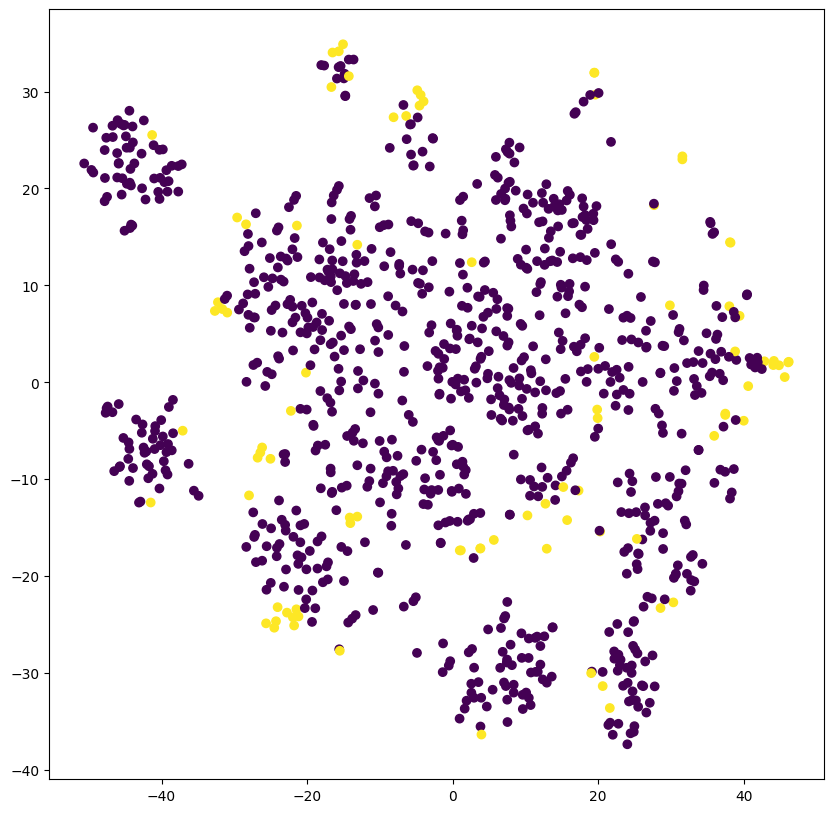


=== Ящик с усами ===


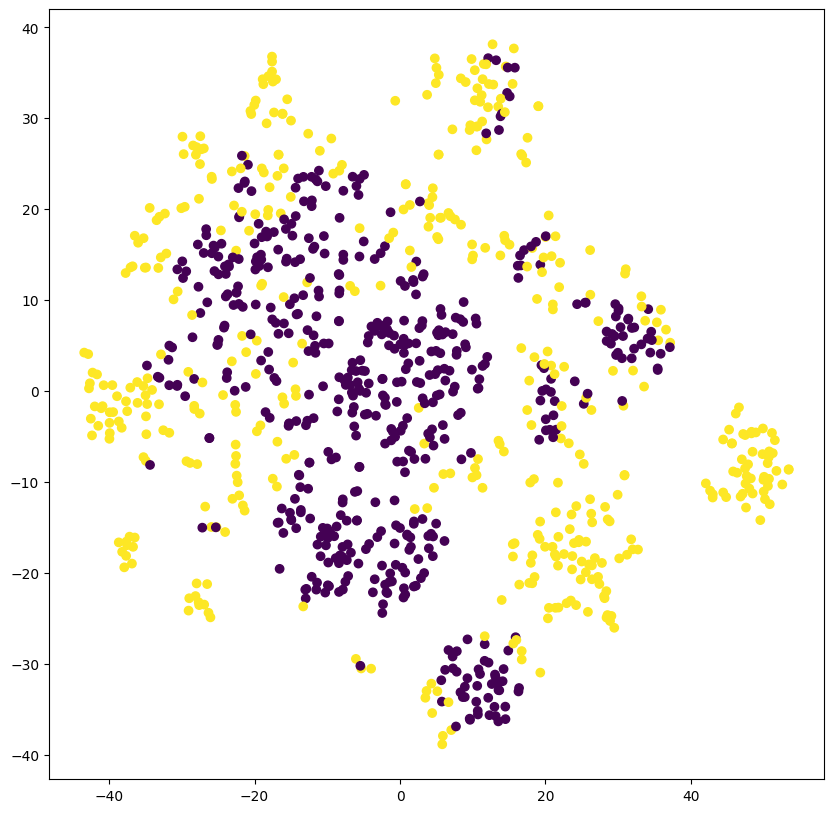


=== Distance-based - евклидово расстояние ===


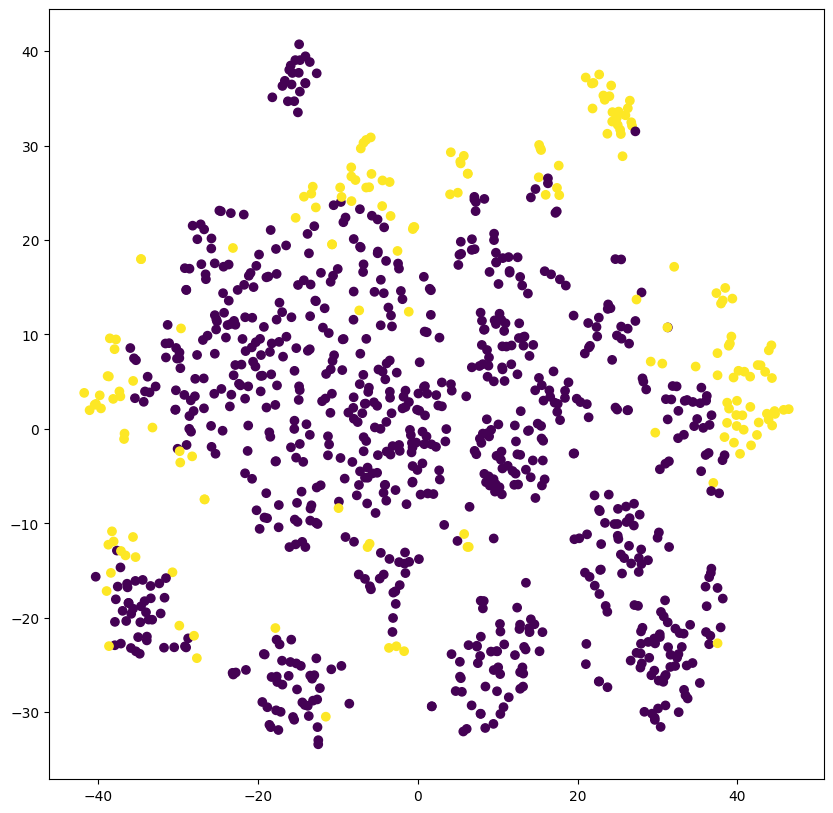


=== Distance-based - манхэттенское расстояние ===


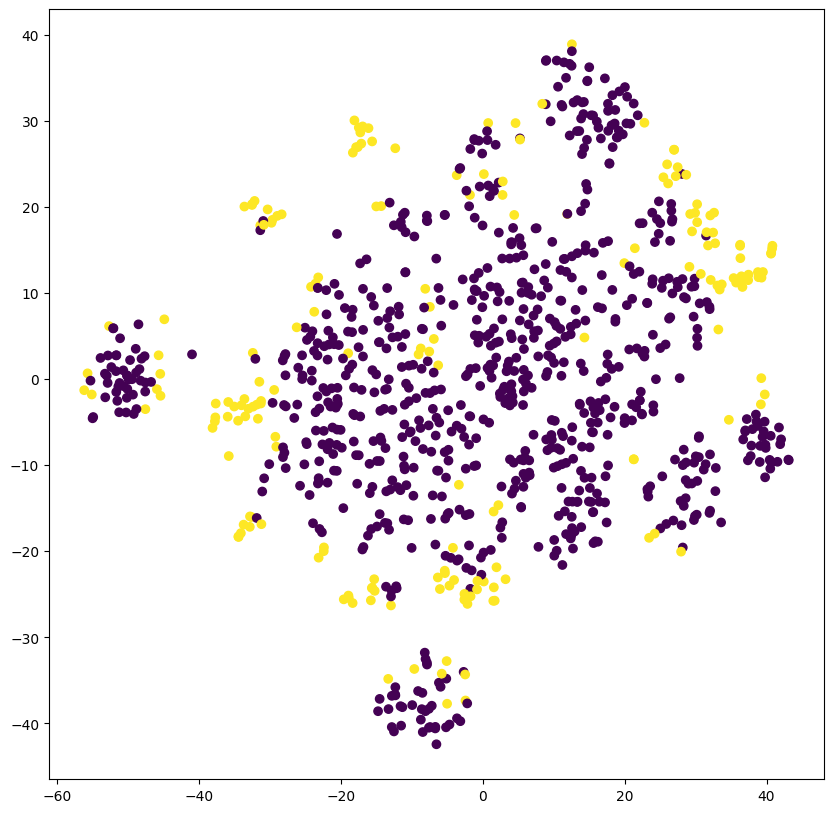


=== DBSCAN ===


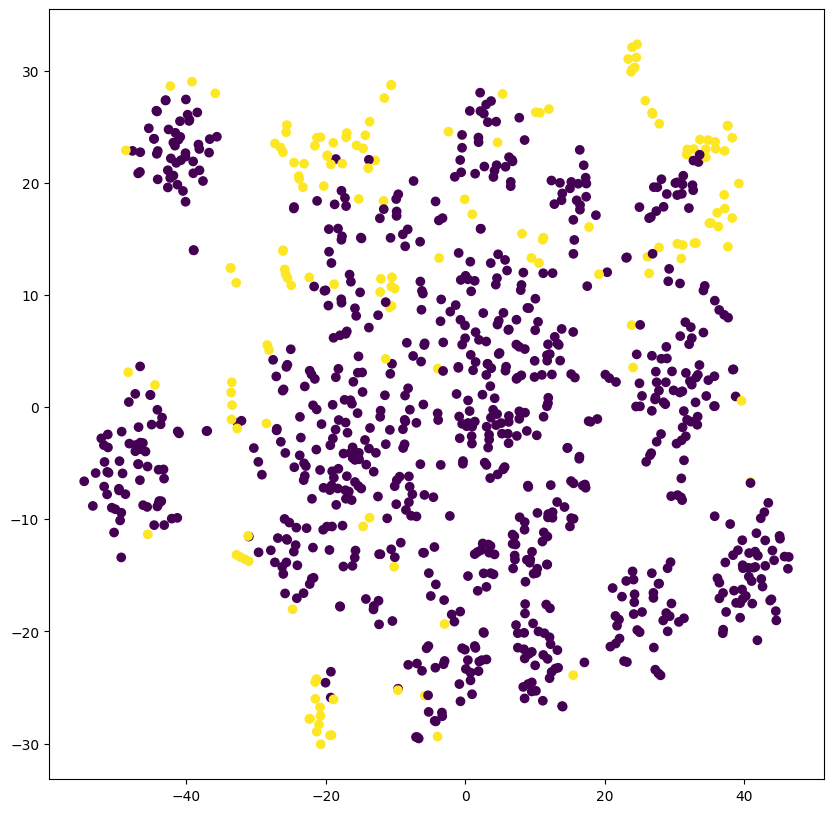


=== SVM ===


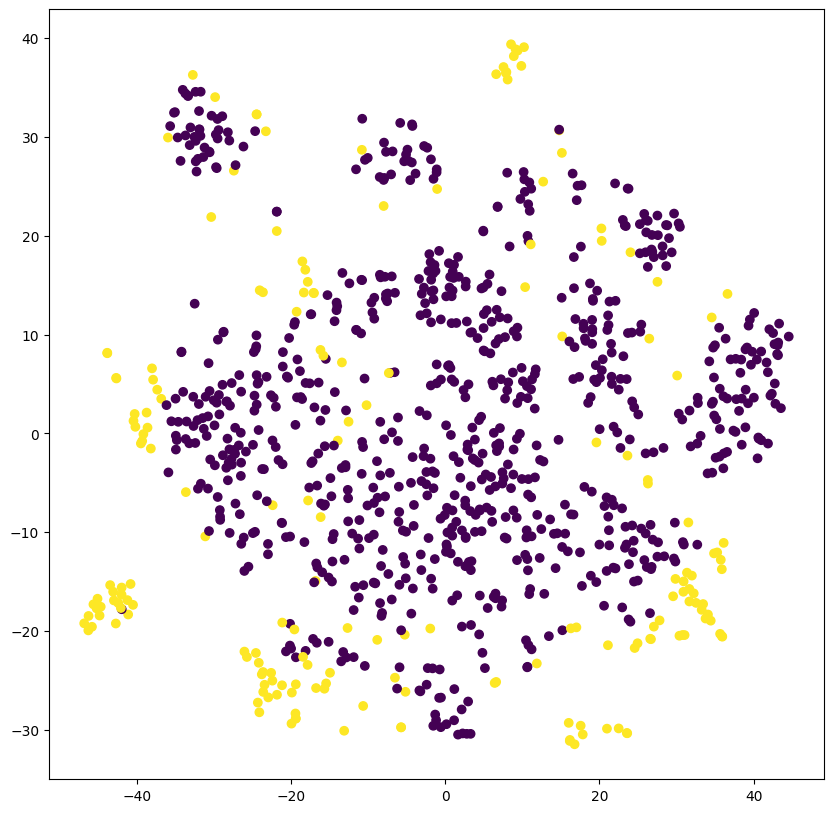


=== Isolation forest ===


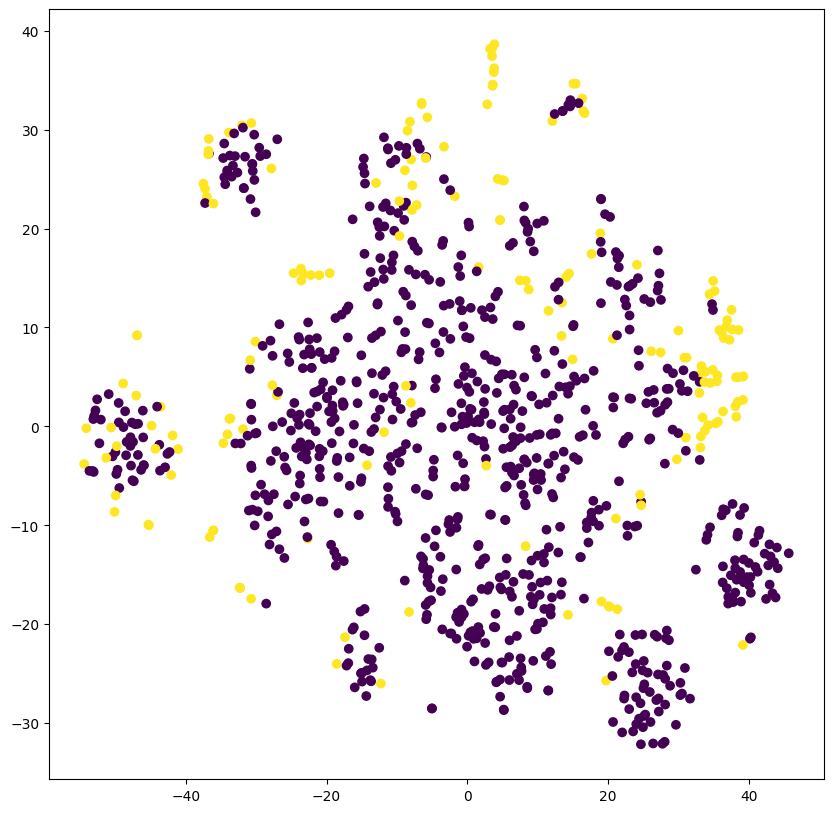

In [88]:
print('=== Три сигмы ===')
show_scatter(X_test, sigmas_labels)
print('\n=== Ящик с усами ===')
show_scatter(X_test, boxplot_labels)
print('\n=== Distance-based - евклидово расстояние ===')
show_scatter(X_test, euclidean_labels)
print('\n=== Distance-based - манхэттенское расстояние ===')
show_scatter(X_test, cityblock_labels)
print('\n=== DBSCAN ===')
show_scatter(X_test, dbscan_labels)
print('\n=== SVM ===')
show_scatter(X_test, svm_labels)
print('\n=== Isolation forest ===')
show_scatter(X_test, isolation_labels)